In [1]:
# basic imports
import pickle
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

# numpyro imports
import arviz as az

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi

import jax
from jax import random
import jax.numpy as jnp

numpyro.set_host_device_count(4)

# Finding the Bag

We are going to use Bayesian inference to estimate where the first bag was thrown.

If you get through this quickly and are up for a ***challenge***, go to the end of the notebook!

First load the experimental data.

In [2]:
with open("bag_data.pkl", "rb") as f:
    bag_data = pickle.load(f)

x_actual = bag_data["x_actual"]
y_actual = bag_data["y_actual"]
x_observations = bag_data["observations"]["x"]
y_observations = bag_data["observations"]["y"]
x_observations = [x for x in x_observations if x in [0, 1]]
y_observations = [y for y in y_observations if y in [0, 1]]

Take a quick look at the data.

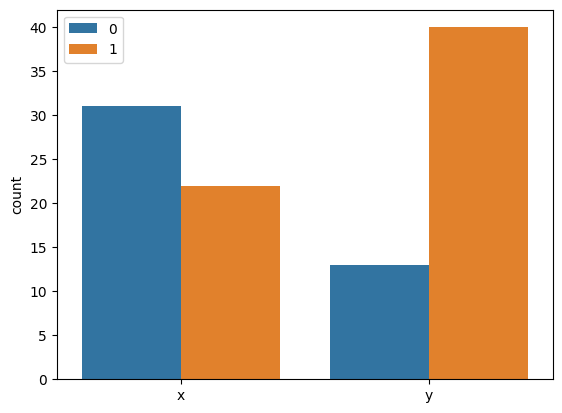

In [3]:
sns.countplot(
    hue=np.concatenate((x_observations, y_observations)),
    x=np.concatenate((["x"] * len(x_observations), ["y"] * len(y_observations)))
)
plt.show()

## By Counting

Start off by purely counting the number of ways the observed events could happen using a discrete grid, one observation at a time.

### One-Dimension

Solve for each dimension (x and y) independently with a set of 10 equally sized bins in each axis. For this section, imagine that the bag takes up the entire bin and you observe a series of observations of bags landing in bins to the right (observation = 1) or to the left (observation = 0).

In [4]:
# setup the bins and their edges
n_bins = 10
bin_grid = np.arange(0, n_bins)
bin_grid_edges = np.linspace(0, 1, n_bins)


def uniform_prior(grid):
    """Returns a uniform probability distribution over a discrete grid."""
    # hint: the probability needs to sum to 1
    return np.repeat(1/len(grid), len(grid))


def bag_bin_approximation(prior, bin_grid, obs):
    """
    Calculates the posterior distribution of the bag's location
    in one dimension based on one observation.
    
    Parameters
    ----------
    prior : np.array
        Prior probability distribution.
    bin_grid : np.array
        Array of bins.
    obs : int
        Observation, 1 = over, 0 = under
    """
    # for each bin, how many ways could this observation have happened?
    # P(E|H) where H is the hypothesis that the bag was in each bin
    if obs == 1:
        likelihood = len(bin_grid) - bin_grid - 1
    else:
        likelihood = bin_grid
    
    # unstandardized posterior
    # P(H) * P(E|H)
    unstd_posterior = likelihood * prior
    
    # standardize the posterior
    posterior = unstd_posterior / sum(unstd_posterior)
    
    return posterior


def plot_binned_posterior(x_actual, y_actual, posterior_x, posterior_y, bin_edges, iteration):
    """A plotting helper function, nothing to do here!
    """
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))
    axs[0].axvline(x_actual, color="red", linestyle="dashed")
    axs[1].axvline(y_actual, color="red", linestyle="dashed")
    axs[0].set(
        xlabel="X",
        ylabel="Posterior Probability"
    )
    axs[1].set(
        xlabel="Y"
    )
    plt.suptitle(f"Observation: {iteration}")
    axs[0].step(bin_edges, posterior_x)
    axs[1].step(bin_edges, posterior_y)
    display.display(plt.gcf())
    display.clear_output(wait=True)

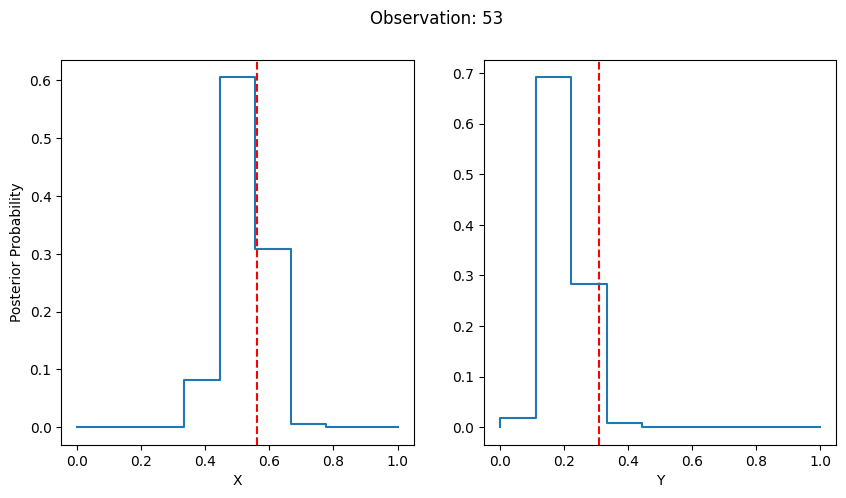

In [5]:
# define priors
posterior_x = uniform_prior(bin_grid)
posterior_y = uniform_prior(bin_grid)

for i, (x_obs, y_obs) in enumerate(zip(x_observations, y_observations)):
    # update the posterior distribution of x and y
    posterior_x = bag_bin_approximation(posterior_x, bin_grid, x_obs)
    posterior_y = bag_bin_approximation(posterior_y, bin_grid, y_obs)
    plot_binned_posterior(x_actual, y_actual, posterior_x, posterior_y, bin_grid_edges, i+1)
    plt.pause(1)

## With Probability Distributions (still just counting!)

Now use the binomial probability mass function and a fine grid to approximate the posterior distribution. This is still counting like what we did before, but the binomial PMF will do the counting for us for the likelihood. Instead of treating the bag as occupying a bin, treat it as if it is at an exact point.

Reference the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html) for how to use the binomial distribution or feel free to implement the [binomial PMF](https://en.wikipedia.org/wiki/Binomial_distribution) yourself.

### One-Dimension

In [6]:
def bag_grid_approximation(prior, p_grid, over, under):
    """
    Calculates the posterior distribution of the bag's location
    in one dimension based on one or many observations.
    
    Parameters
    ----------
    prior : np.array
        Prior probability distribution.
    p_grid : np.array
        Array of parameter values.
    over :
        Number of observations that landed over (observation = 1)
    under :
        Number of observations that landed under (observation = 0)
    """
    # likelihood given data
    # P(E|H) where H is the hypothesis that the bag was in each bin
    likelihood = stats.binom.pmf(under, over + under, p_grid)

    # unstandardized posterior
    # P(H) * P(E|H)
    unstd_posterior = likelihood * prior

    # standardized posterior
    posterior = unstd_posterior / sum(unstd_posterior)
    
    return posterior

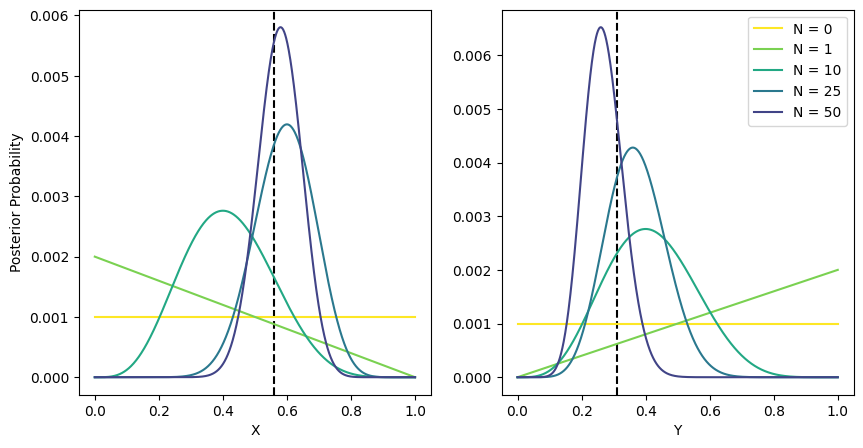

In [7]:
# define a grid of parameter values; feel free to experiment with the size of the grid
grid_length = 1000
p_grid = np.linspace(0, 1, grid_length)

# define uniform priors on x and y
posterior_x = uniform_prior(p_grid)
posterior_y = uniform_prior(p_grid)

# plot setup
plot_n = [0, 1, 10, 25, 50]  # when to plot the posterior distribution
colors = plt.cm.viridis(np.linspace(1, 0, len(plot_n)+1))

fig, axs = plt.subplots(1, 2, figsize = (10, 5))
axs[0].axvline(x_actual, color="black", linestyle="dashed")
axs[1].axvline(y_actual, color="black", linestyle="dashed")
axs[0].set(
    xlabel="X",
    ylabel="Posterior Probability"
)
axs[1].set(
    xlabel="Y"
)

# plot the priors
axs[0].plot(p_grid, posterior_x, color=colors[0], label="N = 0")
axs[1].plot(p_grid, posterior_y, color=colors[0], label="N = 0")

# update the plot with posterior distributions at different numbers of observations
for i, (x_obs, y_obs) in enumerate(zip(x_observations, y_observations)):
    # update the posterior distribution after each observation
    posterior_x = bag_grid_approximation(posterior_x, p_grid, x_obs, 1 - x_obs)
    posterior_y = bag_grid_approximation(posterior_y, p_grid, y_obs, 1 - y_obs)
    if i+1 in plot_n:
        axs[0].plot(p_grid, posterior_x, color=colors[plot_n.index(i+1)], label=f"N = {i+1}")
        axs[1].plot(p_grid, posterior_y, color=colors[plot_n.index(i+1)], label=f"N = {i+1}")
plt.legend()
plt.show()

### Two-Dimensions

Now combine the `x` and `y` posteriors into a joint distribution.

In [8]:
# Make a 2d grid of the x and y posterior distributions
posterior_x_2d = np.repeat(
    np.expand_dims(posterior_x, 1),
    grid_length, axis=1
).T
posterior_y_2d = np.repeat(
    np.expand_dims(posterior_y, 1),
    grid_length, axis=1
)

# multiply the two posterior distributions to make a joint distribution and then standardize
posterior_total = (posterior_x_2d * posterior_y_2d)
posterior_total = posterior_total / posterior_total.sum()

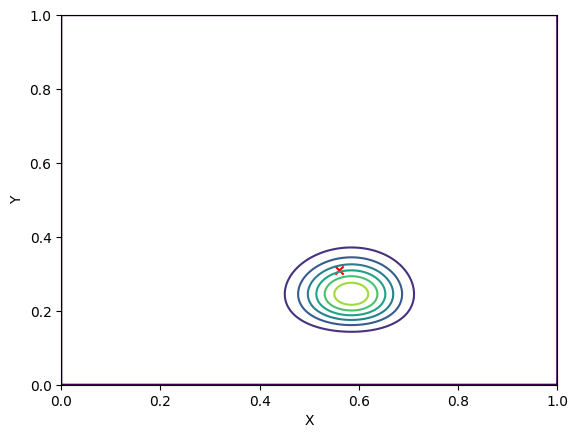

In [9]:
# make a contour plot of the joint distribution
plt.contour(p_grid, p_grid, posterior_total)
# plot the actual location
plt.scatter(x_actual, y_actual, marker="x", color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

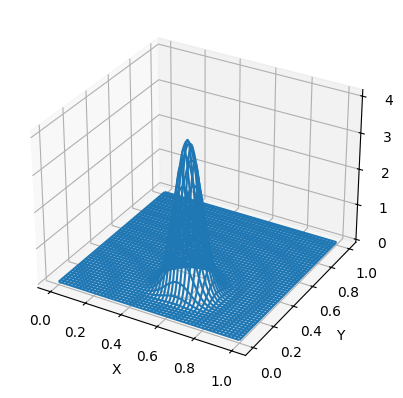

In [10]:
# plot a 3d view of the joint posterior distribution

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

px, py = np.meshgrid(p_grid, p_grid)

ax.plot_wireframe(px, py, posterior_total)
ax.set(
    xlabel="X",
    ylabel="Y",
    zlabel="Posterior Probability"
)
plt.show()

# Introduction to Numpyro

Solve through the previous problem with numpyro to get familiarity before tackling a more realistic modeling problem.

We will also start using statistical notation to help communicate our model. In this case, the model is very simple.

$$
\begin{align*}
    X &\sim \text{Binomial}(N, p_x) \\
    Y &\sim \text{Binomial}(N, p_y) \\
    p_x &\sim \text{Uniform}(0, 1) \\
    p_y &\sim \text{Uniform}(0, 1)
\end{align*}
$$

In [11]:
def bag_model(x_observations, y_observations):
    # define uniform priors for x and y
    # https://num.pyro.ai/en/stable/distributions.html#uniform
    px = numpyro.sample("px", dist.Uniform(low=0.0, high=1.0))
    py = numpyro.sample("py", dist.Uniform(low=0.0, high=1.0))
    
    # sample binomial distributions for x and y
    # https://num.pyro.ai/en/stable/distributions.html#binomial
    n = len(x_observations)
    numpyro.sample("X", dist.Binomial(total_count=n, probs=px), obs=n-x_observations.sum())
    numpyro.sample("Y", dist.Binomial(total_count=n, probs=py), obs=n-y_observations.sum())


# in numpyro we need to manage our own RNG keys
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# define a MCMC object with No-U-Turn Sampler
mcmc_bag_model = MCMC(
    NUTS(bag_model),
    num_warmup=1000,
    num_samples=1000,
    num_chains=4,
    progress_bar=True
)

# run the model
mcmc_bag_model.run(
    rng_key_,
    jnp.array(x_observations),
    jnp.array(y_observations)
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

We should always check diagnostics when using MCMC methods. They are very powerful, but many things can go wrong and result in bad fits of the posterior distribution. In this simple case, everything will behave nicely, but as you move into more complex models (especially hierarchical models) this will not always be the case.

In [12]:
mcmc_bag_model.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        px      0.58      0.06      0.58      0.48      0.70   3202.46      1.00
        py      0.26      0.06      0.25      0.16      0.35   3622.34      1.00

Number of divergences: 0


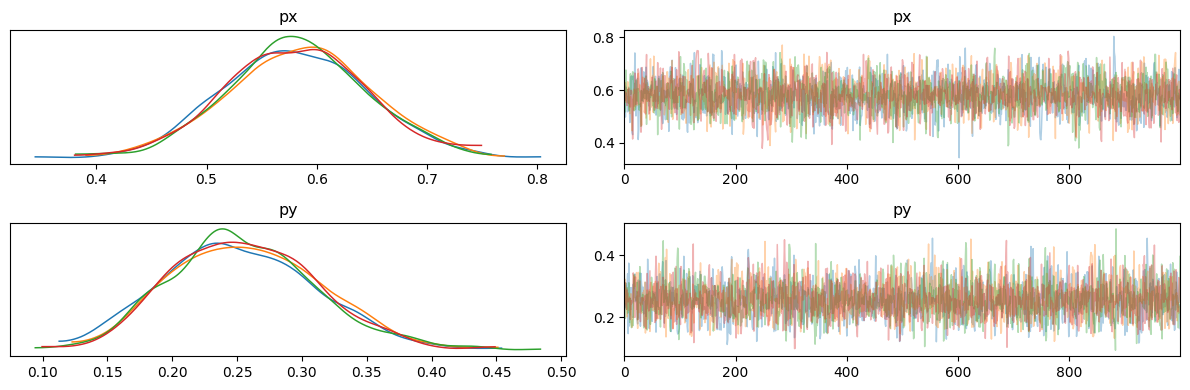

In [13]:
samples = mcmc_bag_model.get_samples()
result = az.from_numpyro(mcmc_bag_model)
az.plot_trace(result, chain_prop="color")
plt.tight_layout()
plt.show()

/home/rgnelson/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rgnelson/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


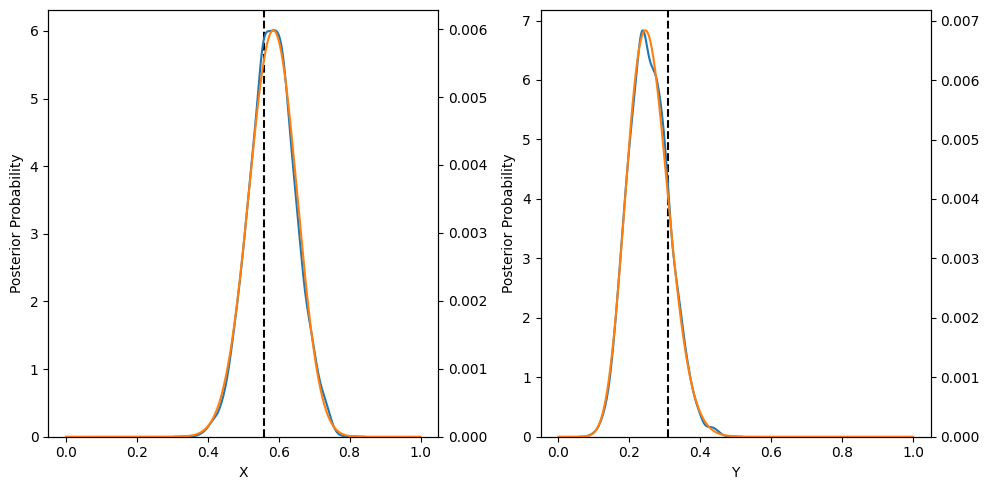

In [14]:
# plot a comparison of the posterior distributions from the grid approximation and MCMC

fig, axs = plt.subplots(1, 2, figsize = (10, 5))
axs[0].axvline(x_actual, color="black", linestyle="dashed")
axs[1].axvline(y_actual, color="black", linestyle="dashed")
axs[0].set(
    xlabel="X",
    ylabel="Posterior Probability"
)
axs[1].set(
    xlabel="Y",
    ylabel="Posterior Probability"
)
# plot kernel density estimates of the x and y posterior samples
# https://seaborn.pydata.org/generated/seaborn.kdeplot.html
sns.kdeplot(samples["px"], color="tab:blue", ax=axs[0])
sns.kdeplot(samples["py"], color="tab:blue", ax=axs[1])

# y-axis on different scales so plot the grid approximation on a twin axis
ax20 = axs[0].twinx()
ax21 = axs[1].twinx()

# plot the grid approximation
ax20.plot(p_grid, posterior_x, color="tab:orange")
ax21.plot(p_grid, posterior_y, color="tab:orange")

ax20.set_ylim(bottom=0)
ax21.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Challenge Questions

If everything above was easy for you, and you want to practice deriving an analytical solution, try the following problems.

## Challenge 1

What is the maximum likelihood estimate for a binomial parameter $\theta$?

## Challenge 2

What is the formula for the *maximum a posteriori* of a binomial random variable given a beta distributed prior with parameters $\alpha$ and $\beta$?

## Challenge 3

What relationships do you see between the MAP and the MLE in this case?

**Hint:** A uniform distribution is equivalent to a beta distribution with $\alpha = \beta = 1$.